Generative Model - a probabilistic model from which a dataset can be generated.

# Mixture model
Fitting a mixture of distributions. Sklearn has Gaussians. I found those two unmaintaind python libraries for exponential families.

http://www.pymix.org/pymix/

http://www.lix.polytechnique.fr/~schwander/darcs/pyMEF/

And there is ROOT: http://theoryandpractice.org/2014/03/roofit-statistical-modeling-language-in-ipython-notebook/

The example due to:
http://nbviewer.ipython.org/github/donnemartin/data-science-ipython-notebooks/blob/master/scikit-learn/scikit-learn-gmm.ipynb

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


For example, imagine we have some one-dimensional data in a particular distribution:

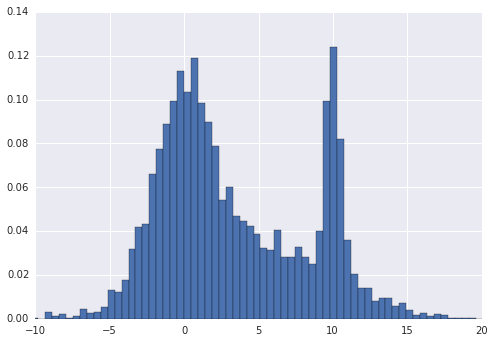

In [2]:
np.random.seed(2)
x = np.concatenate([np.random.normal(0, 2, 2000),
                    np.random.normal(5, 5, 2000),
                    np.random.normal(10, 0.5, 600)])
plt.hist(x, 80, normed=True)
plt.xlim(-10, 20);

Gaussian mixture models will allow us to approximate this density:

(-10, 20)

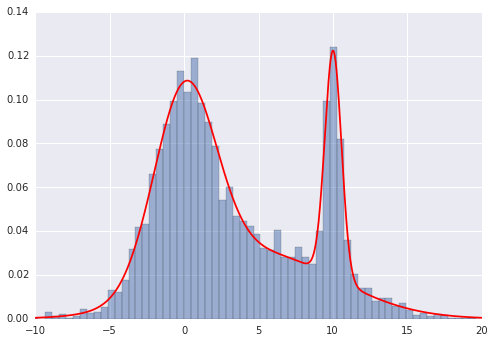

In [10]:
from sklearn.mixture import GMM
clf = GMM(3, n_iter=500, random_state=3, n_init=10).fit(x[:, np.newaxis])
xpdf = np.linspace(-10, 20, 1000)[:, np.newaxis]
density = np.exp(clf.score(xpdf))

plt.hist(x, 80, normed=True, alpha=0.5)
plt.plot(xpdf, density, '-r')
plt.xlim(-10, 20)

Note that this density is fit using a mixture of Gaussians, which we can examine by looking at the means_, covars_, and weights_ attributes:

In [11]:
clf.means_

array([[  5.02299187],
       [  0.04715517],
       [ 10.0156941 ]])

In [12]:
clf.covars_

array([[ 27.10108124],
       [  4.33044298],
       [  0.31054578]])

In [13]:
clf.weights_

array([ 0.38839969,  0.46696122,  0.14463909])

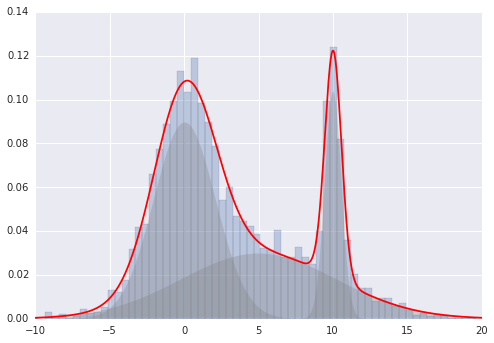

In [14]:
plt.hist(x, 80, normed=True, alpha=0.3)
plt.plot(xpdf, density, '-r')

for i in range(clf.n_components):
    pdf = clf.weights_[i] * stats.norm(clf.means_[i, 0],
                                       np.sqrt(clf.covars_[i, 0])).pdf(xpdf)
    plt.fill(xpdf, pdf, facecolor='gray',
             edgecolor='none', alpha=0.3)
plt.xlim(-10, 20);

## Example: GMM For Outlier Detection

GMM is what's known as a Generative Model: it's a probabilistic model from which a dataset can be generated. One thing that generative models can be useful for is outlier detection: we can simply evaluate the likelihood of each point under the generative model; the points with a suitably low likelihood (where "suitable" is up to your own bias/variance preference) can be labeld outliers.

Let's take a look at this by defining a new dataset with some outliers:

In [15]:
np.random.seed(0)

# Add 20 outliers
true_outliers = np.sort(np.random.randint(0, len(x), 20))
y = x.copy()
y[true_outliers] += 50 * np.random.randn(20)

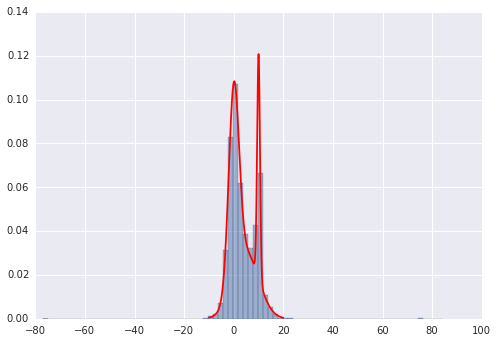

In [9]:
clf = GMM(4, n_iter=500, random_state=0).fit(y[:, np.newaxis])
xpdf = np.linspace(-10, 20, 1000)[:, np.newaxis]
density_noise = np.exp(clf.score(xpdf))

plt.hist(y, 80, normed=True, alpha=0.5)
plt.plot(xpdf, density_noise, '-r')

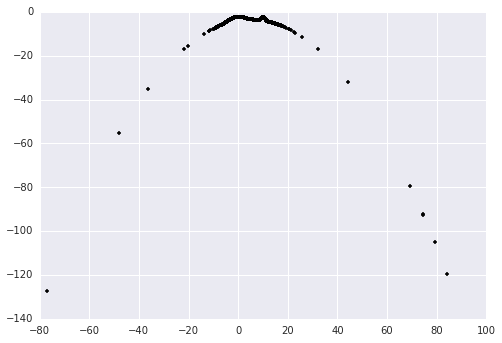

In [17]:
log_likelihood = clf.score_samples(y[:, np.newaxis])[0]
plt.plot(y, log_likelihood, '.k');

In [18]:
detected_outliers = np.where(log_likelihood < -9)[0]

print("true outliers:")
print(true_outliers)
print("\ndetected outliers:")
print(detected_outliers)

true outliers:
[  99  537  705 1033 1653 1701 1871 2046 2135 2163 2222 2496 2599 2607 2732
 2893 2897 3264 3468 4373]

detected outliers:
[  99  537  705 1653 2046 2130 2135 2163 2496 2724 2732 2893 2897 3067 3468
 4373]


The algorithm misses a few of these points, which is to be expected (some of the "outliers" actually land in the middle of the distribution!)

Here are the outliers that were missed:

In [19]:
set(true_outliers) - set(detected_outliers)

{1033, 1701, 1871, 2222, 2599, 2607, 3264}

And here are the non-outliers which were spuriously labeled outliers:

In [13]:
set(detected_outliers) - set(true_outliers)

{2724, 3067}

Finally, we should note that although all of the above is done in one dimension, GMM does generalize to multiple dimensions, as we'll see in the breakout session.

##  Kernel Density Estimation
The other main density estimator that you might find useful is Kernel Density Estimation, which is available via sklearn.neighbors.KernelDensity. In some ways, this can be thought of as a generalization of GMM where there is a gaussian placed at the location of every training point!


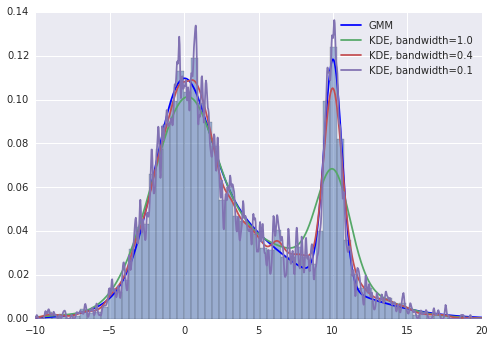

In [14]:
from itertools import izip
from sklearn.neighbors import KernelDensity
density_kdes = list()
bandwidths = (1, 0.4, 0.05)
for bandwidth in bandwidths:
    kde = KernelDensity(bandwidth).fit(x[:, None])
    density_kdes.append(np.exp(kde.score_samples(xpdf)))

plt.hist(x, 80, normed=True, alpha=0.5)
plt.plot(xpdf, density, '-b', label='GMM')
for bandwidth, density_kde in izip(bandwidths, density_kdes):
    plt.plot(xpdf, density_kde, '-', label=r'KDE, bandwidth=%.1f' % bandwidth)
plt.xlim(-10, 20)
plt.legend();